In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys

sys.path.append("../")

In [5]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [7]:
from pathlib import Path

data_path = Path("/data/djaniak/hallucinations/activations/nq_open/llama_3.1_8b_instruct/sampling_multiple_samples__prompt_qa/short_few_shot_sep__seed_42")

In [8]:
!ls {str(data_path)}


activations   config.yaml	    llm_judge.json
answers.json  entropy_metrics.json  llm_judge_config.yaml


In [11]:
import json

with open(data_path / "answers.json", "r") as f:
    answers = json.load(f)

len(answers)


3610

In [12]:
with open(data_path / "entropy_metrics.json", "r") as f:
    entropy_metrics = json.load(f)

len(entropy_metrics)

3610

In [14]:
from hallucinations.metrics.rouge import compute_rouge_score
from hallucinations.metrics.squad import compute_squad_metrics

preds = [answer["low_temperature"] for answer in answers]
golds = [answer["gold"] for answer in answers]

squad_results = compute_squad_metrics(preds, golds, return_reduced=True, return_all=True)
rouge_results = compute_rouge_score(preds, golds, return_reduced=True, return_all=True)

results = {
    "reduced": {**squad_results["reduced"], **rouge_results["reduced"]},  # type: ignore[dict-item]
    "all": [sq | rg for sq, rg in zip(squad_results["all"], rouge_results["all"])],  # type: ignore
}

Evaluating ROUGE metrics: 100%|██████████| 3610/3610 [00:00<00:00, 5725.49it/s]


In [15]:
metrics = []

for m1, m2, a in zip(entropy_metrics, results["all"], answers):
    metrics.append({
        **{"gold": a["gold"]},
        **m1,
        **m2,
    })


In [16]:
import pandas as pd

df_metrics = pd.DataFrame(metrics)
df_metrics.head(1)

,gold,question,high_temp_responses,low_temp_response,cluster_assignment_entropy,predictive_entropy_filtered,predictive_entropy_unfiltered,semantic_entropy_filtered,semantic_entropy_unfiltered,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall
0,"[14 December 1972 UTC, December 1972]",when was the last time anyone was on the moon,"[December 19, 1972 (Apollo 17 mission), Decemb...","December 19, 1972",-0.0,0.578884,0.233352,5.960464e-08,5.960464e-08,0.8,0.0,0.8,0.666667,1.0


In [17]:
from hallucinations.config import LllmJudgeConfig
from hallucinations.utils.misc import load_and_resolve_config, load_json


llm_judge_config_file = data_path / "llm_judge_config.yaml"
if llm_judge_config_file.exists():
    llm_judge_raw_config = load_and_resolve_config(llm_judge_config_file)
    llm_judge_config = LllmJudgeConfig(**llm_judge_raw_config)
    llm_judge_results = pd.DataFrame(
        {"llm_as_judge": load_json(llm_judge_config.evaluation_file)}
    )
    df_metrics = pd.concat([df_metrics, llm_judge_results], axis=1)

df_metrics["llm_as_judge"] = df_metrics["llm_as_judge"].str.lower().str.replace(r"[^a-zA-Z]", "", regex=True)
df_metrics = df_metrics[df_metrics["llm_as_judge"].isin(["correct", "incorrect", "abstaining"])]

In [18]:
df_metrics.head(1)

,gold,question,high_temp_responses,low_temp_response,cluster_assignment_entropy,predictive_entropy_filtered,predictive_entropy_unfiltered,semantic_entropy_filtered,semantic_entropy_unfiltered,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,llm_as_judge
0,"[14 December 1972 UTC, December 1972]",when was the last time anyone was on the moon,"[December 19, 1972 (Apollo 17 mission), Decemb...","December 19, 1972",-0.0,0.578884,0.233352,5.960464e-08,5.960464e-08,0.8,0.0,0.8,0.666667,1.0,incorrect


# Metrics by LLM as judge

In [20]:
df_metrics["llm_as_judge"].value_counts()

llm_as_judge
incorrect     1427
abstaining    1105
correct       1067
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

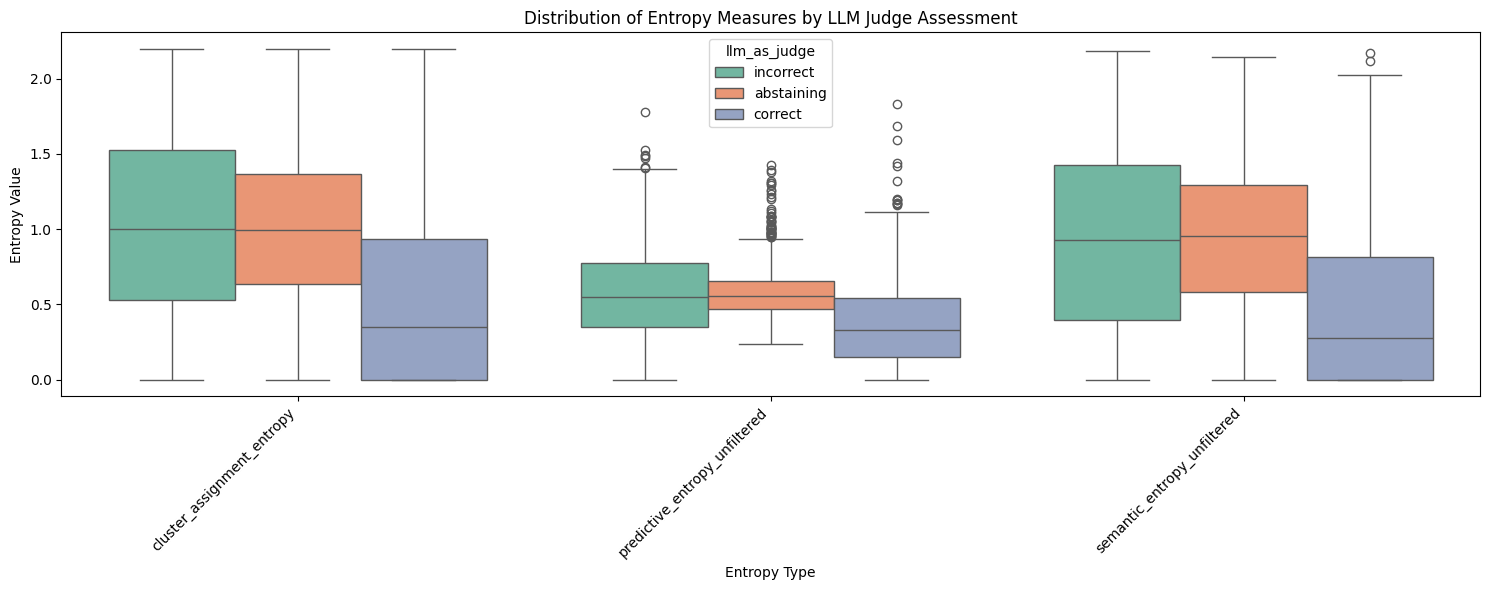

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

entropy_columns = [
    'cluster_assignment_entropy',
    'predictive_entropy_unfiltered',
    'semantic_entropy_unfiltered'
]

# Create box plots for each entropy measure grouped by llm_as_judge
plt.figure(figsize=(15, 6))
data_melted = df_metrics.melt(
    id_vars=['llm_as_judge'], 
    value_vars=entropy_columns,
    var_name='Entropy Type', 
    value_name='Entropy Value'
)

sns.boxplot(
    data=data_melted, 
    x='Entropy Type', 
    y='Entropy Value', 
    hue='llm_as_judge',
    palette='Set2'
)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Entropy Measures by LLM Judge Assessment')
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import roc_auc_score

binary_labels = (df_metrics['llm_as_judge'] == 'correct').astype(int)
binary_labels = binary_labels ^ 1

auroc_scores = {}
for col in entropy_columns:
    auroc = roc_auc_score(binary_labels, df_metrics[col])
    auroc_scores[col] = auroc
    
print("\nAUROC Scores:")
for metric, score in auroc_scores.items():
    print(f"{metric}: {score:.3f}")



AUROC Scores:
cluster_assignment_entropy: 0.719
predictive_entropy_unfiltered: 0.716
semantic_entropy_unfiltered: 0.722


# Metrics by Rogue-L score

In [26]:
df_metrics.columns

Index(['gold', 'question', 'high_temp_responses', 'low_temp_response',
       'cluster_assignment_entropy', 'predictive_entropy_filtered',
       'predictive_entropy_unfiltered', 'semantic_entropy_filtered',
       'semantic_entropy_unfiltered', 'squad_f1', 'squad_exact_match',
       'rougeL_fmeasure', 'rougeL_precision', 'rougeL_recall', 'llm_as_judge'],
      dtype='object')

In [27]:
df_metrics["rogueL_correct"] = df_metrics["rougeL_fmeasure"] > 0.3


<Figure size 1200x600 with 0 Axes>

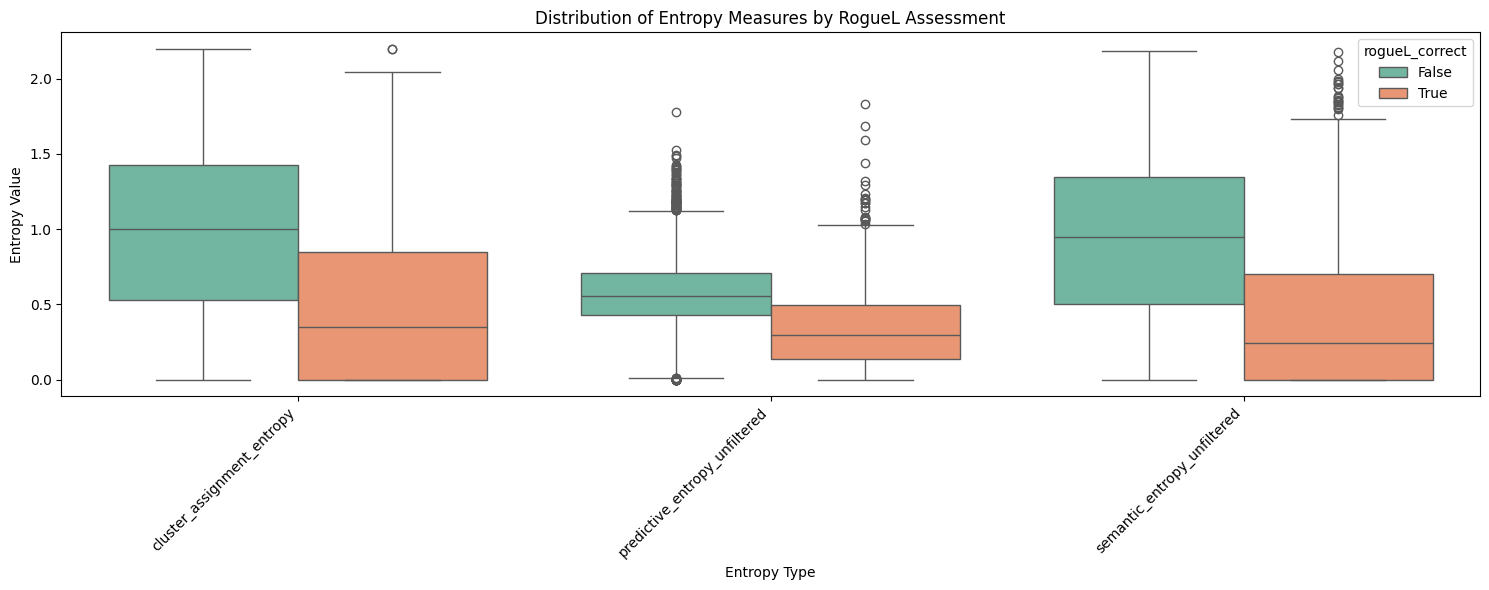

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

entropy_columns = [
    'cluster_assignment_entropy',
    'predictive_entropy_unfiltered',
    'semantic_entropy_unfiltered'
]

# Create box plots for each entropy measure grouped by llm_as_judge
plt.figure(figsize=(15, 6))
data_melted = df_metrics.melt(
    id_vars=['rogueL_correct'], 
    value_vars=entropy_columns,
    var_name='Entropy Type', 
    value_name='Entropy Value'
)

sns.boxplot(
    data=data_melted, 
    x='Entropy Type', 
    y='Entropy Value', 
    hue='rogueL_correct',
    palette='Set2'
)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Entropy Measures by RogueL Assessment')
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import roc_auc_score
import numpy as np

binary_labels = (df_metrics['rogueL_correct'] == True).astype(int)
binary_labels = binary_labels ^ 1

auroc_scores = {}

random_predictions = np.random.rand(len(binary_labels))
auroc_scores['random_baseline'] = roc_auc_score(binary_labels, random_predictions)

for col in entropy_columns:
    auroc = roc_auc_score(binary_labels, df_metrics[col])
    auroc_scores[col] = auroc
    
print("\nAUROC Scores:")
for metric, score in auroc_scores.items():
    print(f"{metric}: {score:.3f}")



AUROC Scores:
random_baseline: 0.491
cluster_assignment_entropy: 0.735
predictive_entropy_unfiltered: 0.754
semantic_entropy_unfiltered: 0.739
